In [1]:
# Familiar imports
import numpy as np
import pandas as pd

# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# For training random forest model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,  RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from datetime import datetime
import gc
from numba import cuda
import os

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from keras import backend as K
import tensorflow as tf
from pandas.util import hash_pandas_object
import hashlib

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1341577361757076398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9898950656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6604092024446162092
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2a:00.0, compute capability: 8.6"
]


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# Load the training data
rawtrain = pd.read_csv("../input/tabular-playground-series-nov-2021/train.csv", index_col=0)
rawtest = pd.read_csv("../input/tabular-playground-series-nov-2021/test.csv", index_col=0)

In [6]:
rawtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Columns: 101 entries, f0 to target
dtypes: float64(100), int64(1)
memory usage: 466.9 MB


In [7]:
import annoy
ann_fname = "./models/annoy1.npy"
ann_train = rawtrain.copy() 
transformer = StandardScaler().fit(ann_train)
ann_train = transformer.transform(ann_train)
ann_train = pd.DataFrame(data=ann_train, index=rawtrain.index, columns=rawtrain.columns)
ann_train.drop(["target"], axis=1, inplace=True)
if os.path.exists(ann_fname):
    f = 100
    ann_idx = annoy.AnnoyIndex(f, 'angular')
    ann_idx.load(ann_fname)
else:   
    f = 100
    ann_idx = annoy.AnnoyIndex(f, 'angular')
    for index, row in ann_train.iterrows():
        ann_idx.add_item(index, row)
    ann_idx.build(64)
    ann_idx.save(ann_fname)

In [8]:
ann_train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,...,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05
mean,-2.486900e-16,5.498653e-16,-1.848595e-16,-1.231607e-17,-2.024573e-16,-6.557836e-16,5.020221e-16,-3.015543e-16,4.177991e-16,1.216449e-16,...,1.594932e-16,3.210706e-16,-7.114901e-17,2.028600e-17,-2.368476e-18,1.450928e-16,3.491133e-17,-5.476863e-16,-2.664535e-17,-8.360720e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-7.855227e+00,-2.394794e+00,-3.895243e+00,-2.600446e+00,-8.105763e+00,-2.384985e+00,-2.403430e+00,-2.487197e+00,-2.465967e+00,-6.428692e+00,...,-3.327214e+01,-2.374167e+00,-1.808369e+01,-3.956981e+01,-7.026692e+00,-6.612998e+00,-2.651774e+00,-2.521090e+00,-9.519664e+00,-1.097197e+01
25%,-5.364845e-01,-8.438471e-01,-4.767998e-01,-7.807393e-01,-3.787915e-01,-8.292945e-01,-8.400459e-01,-7.988755e-01,-8.128648e-01,-2.721238e-01,...,-4.505446e-01,-7.975928e-01,-2.486452e-01,-2.924307e-01,-2.767824e-01,-3.871222e-01,-8.341527e-01,-8.144316e-01,-3.332156e-01,-3.961681e-01
50%,-3.995015e-01,1.216877e-02,-3.135851e-01,-8.916106e-03,-2.784834e-01,2.149922e-02,6.496472e-02,-8.783022e-03,-4.070035e-02,-1.792356e-01,...,-1.482936e-01,-3.735838e-02,-1.574661e-01,-2.309440e-02,-1.763875e-01,-2.116787e-01,3.470647e-02,6.027919e-02,-2.311456e-01,-2.437825e-01
75%,1.735590e-01,8.301332e-01,-7.942616e-03,8.156141e-01,-1.560231e-01,8.043581e-01,8.294525e-01,8.079834e-01,8.258958e-01,-7.898759e-02,...,1.807914e-01,8.099809e-01,-5.487777e-02,2.407781e-01,-6.886846e-02,-2.105475e-02,8.167297e-01,8.192050e-01,-1.104176e-01,-6.861488e-02
max,1.622165e+01,2.399673e+00,1.053503e+01,2.507723e+00,1.937210e+01,2.533230e+00,2.485380e+00,2.379807e+00,2.512349e+00,1.645942e+01,...,5.691483e+01,2.677082e+00,3.329260e+01,8.501020e+01,1.835081e+01,1.697913e+01,2.378367e+00,2.331103e+00,2.431996e+01,2.214102e+01


In [9]:
flip_train = rawtrain.copy()
flip_test = rawtest.copy()
flip_y = flip_train['target'].copy()
flip_x = flip_train.drop(['target'], axis=1)

ole_fname = "./models/ole.npy"
if os.path.exists(ole_fname):
    ordered_label_errors = np.load(ole_fname)
else:
    # Cross validate ridge
    spl = 5
    kf = StratifiedKFold(n_splits=spl, shuffle=True)
    psx = np.zeros((flip_x.shape[0], 2))
    mse = []
    for train_idx, valid_idx in tqdm(kf.split(flip_x, flip_y)):
        model = LogisticRegression(solver="liblinear")
        Xt = flip_x.iloc[train_idx, :]
        yt = flip_y.iloc[train_idx]
        Xv = flip_x.iloc[valid_idx, :]
        yv = flip_y.iloc[valid_idx]
        model.fit(Xt, yt)
        y_pred = model.predict_proba(Xv)
        psx[valid_idx, :] = y_pred
        print(y_pred.shape)

    from cleanlab.pruning import get_noise_indices
    ordered_label_errors = get_noise_indices(
        s=flip_y,
        psx=psx,
        sorted_index_method='normalized_margin', # Orders label errors
    )
    np.save(ole_fname, ordered_label_errors)

In [10]:
def count(ordered_label_errors):
    import annoy
    import numpy as np
    import pandas as pd
    rawtrain = pd.read_csv("../input/tabular-playground-series-nov-2021/train.csv", index_col=0)
    flip_train = rawtrain.copy()
    flip_y = flip_train['target'].copy()
    f = 100
    ann_fname = "./models/annoy1.npy"
    ann_idx = annoy.AnnoyIndex(f, 'angular')
    ann_idx.load(ann_fname)
    bads = np.zeros(ordered_label_errors.shape)
    for i, it in enumerate(ordered_label_errors):
        yit = flip_y[it]
        #print(yit)
        neigh=ann_idx.get_nns_by_item(it, 20)
        #inter = np.intersect1d(ordered_label_errors, neigh)
        #print(inter)
        norm_neigh = np.setdiff1d(neigh, ordered_label_errors)
        #print(flip_y[norm_neigh])
        #plt.hist(flip_y[norm_neigh])
        n_true = (flip_y[norm_neigh] == flip_y[it]).sum()
        n_false = (flip_y[norm_neigh] != flip_y[it]).sum()
        ratio = n_false / (n_true + n_false)
        bads[i]=ratio
    return [ordered_label_errors, bads]

In [11]:
bads_fname="./models/bads.npy"
badsi_fname = "./models/bads_i.npy"
if os.path.exists(bads_fname):
    badsi = np.load(badsi_fname)
    bads = np.load(bads_fname)
else:
    from pathos.multiprocessing import ProcessingPool as Pool
    # checking errors with annoy
    bads = []
    badsi = []
    with Pool(processes=10) as p:
        for part in p.imap(count, np.array_split(ordered_label_errors, 60)):
            badsi.append(part[0])
            bads.append(part[1])
    bads = np.concatenate(bads, axis=0)
    badsi = np.concatenate(badsi, axis=0)
    np.save(bads_fname, bads)
    np.save(badsi_fname, badsi)


In [12]:
print(bads)
print(badsi)

[1.         1.         1.         ... 0.73684211 0.57894737 0.42105263]
[415753 288596 165241 ...  95208 234563 454154]


(array([  100.,  1126.,  6104., 17523., 34845., 23475., 38151., 22226.,
         5924.,   527.]),
 array([0.05263158, 0.14736842, 0.24210526, 0.33684211, 0.43157895,
        0.52631579, 0.62105263, 0.71578947, 0.81052632, 0.90526316,
        1.        ]),
 <BarContainer object of 10 artists>)

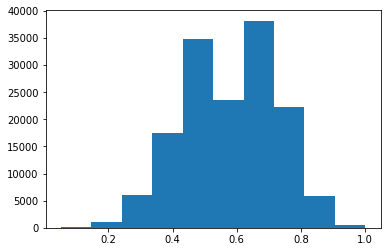

In [13]:
plt.hist(bads)

In [14]:
badsi[bads > 0.6].size

68742

In [15]:
train = rawtrain.copy()
prey = train['target'].copy()
features = train.drop(['target'], axis=1)

In [16]:
preX = features.copy()
preX.shape

(600000, 100)

(array([75169.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 74832.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

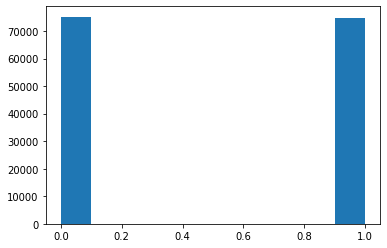

In [17]:
plt.hist(prey[ordered_label_errors])

In [18]:
#df = df.drop(df[df.score < 50].index)

In [19]:
X = preX#.drop(ordered_label_errors)
X.shape

(600000, 100)

In [20]:
y = prey#.drop(ordered_label_errors)
#y[ordered_label_errors] = 1 - y[ordered_label_errors]
y.shape

(600000,)

In [21]:
test = rawtest.copy()
test.shape

(540000, 100)

In [22]:
lgbm_parameters = {
    "device":'gpu', "metric":"auc",
  'learning_rate': 0.088202251342637, 'max_depth': 9, 'min_data_in_leaf': 622, 'n_estimators': 6675, 'num_leaves': 2, 'reg_alpha': 3.2551114904483622, 'reg_lambda': 4.3256459403144465
}
xgboost_parameters = { 'n_jobs':4, 
                       'tree_method': 'gpu_hist', 
                        'gpu_id': 0,
'alpha': 6.585083548901454, 'gamma': 0.010815026816252349, 'lambda': 3.7699082658342555, 'learning_rate': 0.05935377531038842, 'max_depth': 1, 'min_child_weight': 44.52085850052923, 'n_estimators': 11303, 'subsample': 0.9220131617216115
}

catboost_parameters={
    'task_type':"GPU", "loss_function":"RMSE",
'bagging_temperature': 4.021848378181608, 'depth': 7, 'iterations': 9560, 'l2_leaf_reg': 98.16696275126748, 'learning_rate': 0.031190673582301456
}

In [23]:
class KerasModel:
    def __init__(self, model, session):
        self.model = model
        self.session = session
    def predict(self, test):
        out = self.model.predict(test)
        return np.reshape(out,(out.size,))
    def predict_proba(self, test):
        out = self.model.predict(test)
        return np.reshape(out,(out.size,)) 

input_shape = [X.shape[1]]
def create_keras():
    model = keras.Sequential([
        layers.BatchNormalization(input_shape = input_shape),
        layers.GaussianNoise(stddev=0.2),
        layers.Dense(units = 4096, activity_regularizer=regularizers.l1(10e-5)),
        layers.LeakyReLU(alpha=0.05),
        layers.BatchNormalization(),
        layers.Dropout(rate = 0.3),
        layers.Dense(units = 512),
        layers.LeakyReLU(alpha=0.05),
        layers.BatchNormalization(),
        layers.Dropout(rate = 0.3),
        layers.Dense(units = 4096),
        layers.LeakyReLU(alpha=0.05),
        layers.BatchNormalization(),
        layers.Dropout(rate = 0.3),
        layers.Dense(units = 1, activation = 'hard_sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC()]
    )
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.allow_growth=True
    session = tf.compat.v1.Session(config=config)
    return KerasModel(model, session)

def fit_keras(model, Xt, yt, Xv, yv):
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001, # minimium amount of change to count as an improvement
        patience=100, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.model.fit(Xt, yt, validation_data=(Xv, yv), 
    callbacks = [early_stopping, tensorboard_callback], 
        batch_size=6000, epochs=600, verbose=1)
    del history
def predict_keras(model, Xt):
    return model.predict(Xt)
def clear_keras(model):
    gc.collect()
    del model.model   
    model.session.close()
    del model.session
    gc.collect()
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    gc.collect()
def shutdown_keras():
    device = cuda.get_current_device()
    device.reset()

In [24]:
def fit_catboost(model, Xt, yt, Xv, yv):
    model.fit(Xt, yt, early_stopping_rounds = 400, eval_set=[(Xv, yv)], verbose = 0)
def fit_lgbm(model, Xt, yt, Xv, yv):
    model.fit(Xt, yt, early_stopping_rounds = 399, eval_set=[(Xv, yv)], verbose = -1)  
def fit_xgboost(model, Xt, yt, Xv, yv):
    model.fit(Xt, yt, early_stopping_rounds = 400, eval_set=[(Xv, yv)], verbose=False)
def predict_catboost(model, Xt):
    return model.predict(Xt)
def predict_lgbm(model, Xt):
    return model.predict(Xt)
def predict_xgboost(model, Xt):
    return model.predict_proba(Xt)[:, 1]
    
model_types = [
   {"name": "keras", "create": create_keras, "fit": fit_keras, "predict":predict_keras, "clear": clear_keras, "shutdown": shutdown_keras},
   # {"name": "lgbm", "create": lambda: LGBMRegressor(**lgbm_parameters), "fit": fit_lgbm, "predict": predict_lgbm },
   # {'name': 'xgboost', 'create': lambda: XGBClassifier(**xgboost_parameters, eval_metric="auc", use_label_encoder=False), 'fit': fit_xgboost, 'predict': predict_xgboost},
   # {"name": "catboost", "create": lambda: CatBoostRegressor(**catboost_parameters), "fit": fit_catboost, "predict": predict_catboost},
]

In [25]:
model_types

[{'name': 'keras',
  'create': <function __main__.create_keras()>,
  'fit': <function __main__.fit_keras(model, Xt, yt, Xv, yv)>,
  'predict': <function __main__.predict_keras(model, Xt)>,
  'clear': <function __main__.clear_keras(model)>,
  'shutdown': <function __main__.shutdown_keras()>}]

In [26]:
input_hash = str(hash(hashlib.sha256(pd.util.hash_pandas_object(X, index=True).values).hexdigest()))

In [27]:
splits_file="./models/splits_"+ str(input_hash) + ".npy"
if os.path.exists(splits_file):
    print("splits from file")
    splits_arr = np.load(splits_file, allow_pickle=True)
    splits = splits_arr[0]
else:
    print("generating splits")
    spl = 10
    kf = StratifiedKFold(n_splits=spl, shuffle=True)
    split_list=[]
    for train_idx, valid_idx in kf.split(X,y.round()):
        split_list.append({"train": train_idx.copy(), "valid": valid_idx.copy()})
    splits = {}
    splits["list"] = split_list
    hashes = []
    hashes.append(hash(str(split_list)))
    hashes.append(input_hash)
    splits["hash"] = hash(str(hashes))
    splits["spl"] = spl
    np.save(splits_file, [splits])
spl = splits['spl']

generating splits


In [ ]:
out_of_fold_predictions = np.zeros((X.shape[0], len(model_types)))
meta_features = np.zeros((test.shape[0], len(model_types)))
y_pred = []
for i, model_type in enumerate(model_types):
    print("starting " + model_type["name"])
    model_fname = "./models/"+model_type["name"] +"_"+str(splits["hash"])+".npy"
    if os.path.exists(model_fname):
        print("loading model")
        model_data_arr = np.load(model_fname, allow_pickle=True)
        model_data = model_data_arr[0]
    else:
        print("fitting model")
        mse = []
        meta_features_folds = np.zeros((test.shape[0], spl))
        out_of_fold_predictions_folds = np.zeros((X.shape[0], ))
        for i_fold, split in enumerate(tqdm(splits["list"])):
            train_idx = split["train"]
            valid_idx = split["valid"]
            Xt = X.iloc[train_idx, :]
            yt = y.iloc[train_idx]
            Xv = X.iloc[valid_idx, :]
            yv = y.iloc[valid_idx]
            model = model_type['create']()
            model_type['fit'](model, Xt, yt, Xv, yv)
            y_pred = model_type['predict'](model, Xv)
            out_of_fold_predictions_folds[valid_idx] = y_pred
            valid_mse = roc_auc_score(y_true = yv, y_score = y_pred)
            mse.append(valid_mse)
            meta_features_folds[:, i_fold] = model_type['predict'](model, test)
            print("validation quality metric", valid_mse)
            if "clear" in model_type:
                print("clearing")
                model_type["clear"](model)
            del model
            gc.collect()
        if "shutdown" in model_type:
            print("shutting down")
            model_type["shutdown"]()
        meta_features_folds = meta_features_folds.mean(axis=1)
        model_data={}
        model_data['meta_features_folds'] = meta_features_folds
        model_data['out_of_fold_predictions_folds'] = out_of_fold_predictions_folds
        model_data['mse'] = mse
        model_data_arr = [model_data]
        np.save(model_fname, model_data_arr)
    meta_features[:, i] = model_data['meta_features_folds']
    out_of_fold_predictions[:, i] = model_data['out_of_fold_predictions_folds']
    mse = model_data['mse']
    print(model_type["name"], i, mse, " max ", max(mse), " min ", min(mse)," avg ", sum(mse)/len(mse))

starting keras
fitting model


  0%|                                                                                               | 0/10 [00:00<?, ?it/s]

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2a:00.0, compute capability: 8.6

Epoch 1/600
90/90 [==============================] - 10s 80ms/step - loss: 5.1920 - auc: 0.6328 - val_loss: 5.2670 - val_auc: 0.6100
Epoch 2/600
90/90 [==============================] - 4s 48ms/step - loss: 6.7401 - auc: 0.5490 - val_loss: 6.7517 - val_auc: 0.5373
Epoch 3/600
90/90 [==============================] - 2s 27ms/step - loss: 6.2334 - auc: 0.5820 - val_loss: 6.0506 - val_auc: 0.5918
Epoch 4/600
90/90 [==============================] - 2s 27ms/step - loss: 5.7319 - auc: 0.6140 - val_loss: 5.5055 - val_auc: 0.6276
Epoch 5/600
90/90 [==============================] - 2s 27ms/step - loss: 5.3149 - auc: 0.6414 - val_loss: 5.4338 - val_auc: 0.6342
Epoch 6/600
90/90 [==============================] - 2s 26ms/step - loss: 5.4698 - auc: 0.6318 - val_loss: 5.6146 - val_auc: 0.6226
Epoch 7/600
90/90 [============================

 10%|████████▌                                                                             | 1/10 [06:30<58:36, 390.72s/it]

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2a:00.0, compute capability: 8.6

Epoch 1/600
90/90 [==============================] - 3s 29ms/step - loss: 5.6707 - auc: 0.6022 - val_loss: 4.8978 - val_auc: 0.6150
Epoch 2/600
90/90 [==============================] - 2s 26ms/step - loss: 6.5823 - auc: 0.5597 - val_loss: 6.7265 - val_auc: 0.5314
Epoch 3/600
90/90 [==============================] - 2s 26ms/step - loss: 6.3095 - auc: 0.5764 - val_loss: 7.2688 - val_auc: 0.5091
Epoch 4/600
90/90 [==============================] - 2s 26ms/step - loss: 7.1147 - auc: 0.5262 - val_loss: 6.2424 - val_auc: 0.5887
Epoch 5/600
90/90 [==============================] - 2s 26ms/step - loss: 6.5104 - auc: 0.5702 - val_loss: 6.3174 - val_auc: 0.5822
Epoch 6/600
90/90 [==============================] - 2s 26ms/step - loss: 6.1094 - auc: 0.5953 - val_loss: 6.2715 - val_auc: 0.5850
Epoch 7/600
90/90 [=============================

In [ ]:
meta_model = Ridge()

In [ ]:
# Cross validate ridge
spl = 10
kf = StratifiedKFold(n_splits=spl, shuffle=True)
test_pred_total = np.zeros(len(rawtest))
mse = []
for train_idx, valid_idx in tqdm(kf.split(out_of_fold_predictions,y.round())):
        model = meta_model
        Xt = out_of_fold_predictions[train_idx, :]
        yt = y.iloc[train_idx]
        Xv = out_of_fold_predictions[valid_idx, :]
        yv = y.iloc[valid_idx]
        model.fit(Xt, yt)
        y_pred = model.predict(Xv)
        valid_mse = roc_auc_score(y_true = y.iloc[valid_idx], y_score = y_pred)
        print("valid qlty ", valid_mse)
        mse.append(valid_mse)
        test_pred = model.predict(meta_features) / spl
        test_pred_total += test_pred
print("valid qlty", mse, " min ", min(mse), " max ", max(mse), " avg ", sum(mse)/len(mse))

In [ ]:
# Save the predictions to a CSV file
output = pd.DataFrame({'Id': rawtest.index,
                       'target': test_pred_total})
output.to_csv('submission.csv', index=False)

In [ ]:
from datetime import datetime
print(datetime.now())